In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import brentq, fmin
from tabulate import tabulate

In [2]:
# data = pd.read_csv('F:\workspace\ipython\ECON3334\caschool.csv')
df = pd.read_csv("https://raw.githubusercontent.com/gerald-liu/ipython/master/ECON3334/caschool.csv",
                 usecols=['testscr', 'str', 'el_pct', 'meal_pct', 'avginc'])

In [3]:
df['str_X_elpct'] = df['str'].mul(df['el_pct'])
df['loginc'] = df['avginc'].apply(np.log)
df = df[['testscr', 'str', 'el_pct', 'str_X_elpct', 'meal_pct', 'loginc']]

In [5]:
lm = smf.ols(formula='testscr ~ ' + ' + '.join(df.columns.tolist()[1:6]), data=df).fit(cov_type='HC1')
lm_table = pd.DataFrame({'Coefficient':lm.params, 'SE':lm.bse, 't-stat':lm.tvalues})
lm_table['p-value'] = lm.pvalues
lm_table = pd.concat([lm_table, lm.conf_int().rename(columns={0: '95%CI_LB', 1: '95%CI_UB'})], axis=1)
print (tabulate(lm_table, lm_table.columns, tablefmt="latex"))

\begin{tabular}{lrrrrrr}
\hline
             &   Coefficient &         SE &    t-stat &     p-value &     95\%CI\_LB &      95\%CI\_UB \\
\hline
 Intercept   &   663.158     & 10.0543    &  65.9573  & 0           & 643.451      & 682.864       \\
 str         &    -0.946666  &  0.346875  &  -2.72913 & 0.00635018  &  -1.62653    &  -0.266804    \\
 el\_pct      &    -0.481824  &  0.246129  &  -1.95761 & 0.0502763   &  -0.964228   &   0.000580411 \\
 str\_X\_elpct &     0.0154803 &  0.012334  &   1.2551  & 0.209444    &  -0.00869384 &   0.0396545   \\
 meal\_pct    &    -0.40138   &  0.0332698 & -12.0644  & 1.62858e-33 &  -0.466587   &  -0.336172    \\
 loginc      &    11.4331    &  1.81773   &   6.28974 & 3.17999e-10 &   7.87038    &  14.9958      \\
\hline
\end{tabular}


$$
\begin{aligned}
\Delta testscr &= (\beta_1+\beta_3\cdot el\_pct)\sigma_{str} \\
&= \beta_1\sigma_{str}+\beta_3\sigma_{str}\cdot el\_pct \\
\ \\
SE(\Delta testscr) &= \sqrt{var(\beta_1)\sigma_{str}^2+var(\beta_3)\sigma_{str}^2(el\_pct)^2+2 \cdot \sigma_{str}^2 cov(\beta_1, \beta_3)\cdot el\_pct}
\end{aligned}
$$

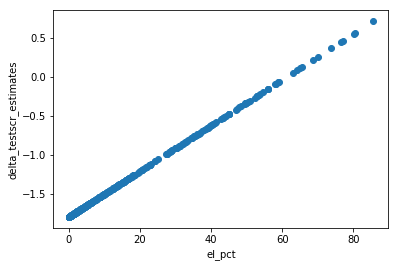

In [6]:
plt.scatter(df['el_pct'], df['el_pct'].apply(lambda x: (lm.params[1] + lm.params[3]*x) * df['str'].std()))
plt.xlabel('el_pct')
plt.ylabel('delta_testscr_estimates')
plt.savefig('hw5_2.png')

$$
\begin{aligned}
H_0: \Delta testscr &= \beta_1\sigma_{str}+\beta_3\sigma_{str}\cdot el\_pct = 0 \\
H_1: \Delta testscr &\neq 0
\end{aligned}
$$

In [7]:
def se_dy(x, var_0, var_1, cov): # y = b_0 + b_1 x
    return math.sqrt(var_0 + x**2 * var_1 + 2*x*cov)

var_0 = lm.bse[1]**2
var_1 = lm.bse[3]**2
f = lm.f_test('str + str_X_elpct = 0').fvalue[0][0]
cov = ((lm.params[1]+lm.params[3])**2 /f - lm.bse[1]**2 - lm.bse[3]**2)/2

In [8]:
print(lm.params[1]*df['str'].std(), lm.params[3]*df['str'].std(), var_0, var_1, f, cov)

-1.7909139933774925 0.029285870569600532 0.12032207305089052 0.00015212727799763655 7.568291087086314 -0.002951589033988682


In [9]:
el_pct_test = pd.Series(np.arange(1, 81))
df_1 = pd.DataFrame({'se_dy': el_pct_test.apply(se_dy, args=(var_0, var_1, cov,)), 'el_pct': el_pct_test})
df_1['t-stat'] = (lm.params[1] + lm.params[3]*df_1['el_pct'])/df_1['se_dy']
# df_1['95%CI_LB'] = df_1['t-stat'] + norm.ppf(0.05/2)*df_1['se_dy']
# df_1['95%CI_UB'] = df_1['t-stat'] - norm.ppf(0.05/2)*df_1['se_dy']

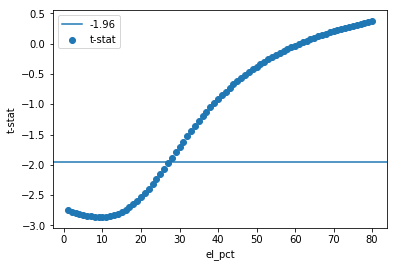

In [10]:
plt.scatter(df_1['el_pct'], df_1['t-stat'])
# plt.scatter(df_1['el_pct'], df_1['95%CI_LB'])
# plt.scatter(df_1['el_pct'], df_1['95%CI_UB'])
plt.axhline(y=norm.ppf(0.05/2), label='-1.96')
plt.xlabel('el_pct')
plt.ylabel('t-stat')
plt.legend()
plt.savefig('hw5_4.png')

In [11]:
def t_dy(x, var_0, var_1, cov):
    return (lm.params[1] + lm.params[3]*x)/se_dy(x, var_0, var_1, cov)

def solver(x, var_0, var_1, cov, c):
    return t_dy(x, var_0, var_1, cov) - c

fm = fmin(t_dy, 10, args=(var_0, var_1, cov,), disp=False)

print("For el_pct < {:.4f}, the change in testscr is significant at 5% level.".format(brentq(solver, 20, 30,
                                                                                             args=(var_0, var_1, cov,
                                                                                                   norm.ppf(0.05/2),))),
      "\nFor el_pct < {:.4f} and el_pct > {:.4f}, the significance increases as el_pct increases;\n".format(fm[0],
                                                                                                brentq(solver, 60, 70,
                                                                                                  args=(var_0, var_1, cov, 0))),
      "\telse, the significance decreases as el_pct increases.")

x_t_max = 9 if t_dy(9, var_0, var_1, cov) < t_dy(10, var_0, var_1, cov) else 10
print("The maximum significance level {:.2%} is acheived at t-stat = {}.".format(2*norm.cdf(t_dy(x_t_max,
                                                                                                       var_0, var_1, cov)),
                                                                                       x_t_max))

For el_pct < 27.1408, the change in testscr is significant at 5% level. 
For el_pct < 9.4744 and el_pct > 61.1528, the significance increases as el_pct increases;
 	else, the significance decreases as el_pct increases.
The maximum significance level 0.42% is acheived at t-stat = 9.
